# Object Detection with YOLOv8 (+ how to convert our own dataset to yolo format) (estimated time 20-30 mins)
<br>Last updated on 29/08/2024</br>
    <br>We aim to detect objects consisting of 20 classes: person, bird, cat, dog, horse, sheep, aeroplane, bicycle, boat, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, and TV monitor. **Pascal VOC Detection Dataset** (http://host.robots.ox.ac.uk/pascal/VOC/) and **YOLOv8** (https://docs.ultralytics.com/datasets/detect/voc/) are employed for the trial. The code is modified form https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb. <br>

     from previous notebook we using their dataset that been set up for yolo. now, we will learn about custom our own dataset.


In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


## Download Pascal-VOC 2007 dataset

In [2]:
# Import necessary libraries
import os
import requests
import tarfile
from tqdm import tqdm

In [3]:
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    filename = os.path.join(dest_folder, url.split('/')[-1])

    if os.path.isfile(filename):
        print(f"{filename} already exists. Skipping download.")
        return filename

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as f, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    return filename

def extract_tar(tar_file, extract_to_folder):
    with tarfile.open(tar_file, 'r') as tar_ref:
        tar_ref.extractall(extract_to_folder)

In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [5]:
# Download and extract VOC 2007
base_url = "http://host.robots.ox.ac.uk:8080/pascal/VOC/voc2007/"
files = {
    'VOCtrainval_06-Nov-2007.tar': 'VOCtrainval_06-Nov-2007.tar',
    'VOCtest_06-Nov-2007.tar': 'VOCtest_06-Nov-2007.tar'
}

download_folder = '/content/voc2007'
for url, filename in files.items():
    print(f"Downloading {filename}...")
    tar_path = download_file(base_url + filename, download_folder)
    print(f"Extracting {filename}...")
    extract_tar(tar_path, download_folder)
    print(f"{filename} extracted.")

/content/voc2007/VOCtrainval_06-Nov-2007.tar: 100%|██████████| 439M/439M [00:26<00:00, 17.7MiB/s]


Extracting VOCtrainval_06-Nov-2007.tar...
VOCtrainval_06-Nov-2007.tar extracted.


/content/voc2007/VOCtest_06-Nov-2007.tar: 100%|██████████| 430M/430M [00:29<00:00, 15.1MiB/s]


Extracting VOCtest_06-Nov-2007.tar...
VOCtest_06-Nov-2007.tar extracted.


## Convert VOC format (.xml) to Yolo format (.yaml)

In [6]:
import os
import cv2
import xml.etree.ElementTree as ET
from glob import glob
from sklearn.model_selection import train_test_split
import shutil

**To train yolo on custom dataset** we need to setup dataset to  thier structure <br>
( that can see in /content/yolo_annotations) <br>

---

**Yolo .yaml file** need dataset folder that contains <br>
1. train folder <br>
2. val folder <br>

>**Yolo directory** <br>
dataset/<br>
├── images/ <br>
│  &emsp; ├── train/ <br>
│  &emsp;  &emsp; &emsp; ├── 000001.jpg (original image)<br>
│  &emsp; └── val/ <br>
└── labels/ <br>
 &ensp;  &emsp; ├── train/ <br>
 &ensp;  &emsp; └── val/ <br>
 &ensp; &emsp;  &emsp; &emsp; ├── 000001.txt (annotation)<br>


each line of text file is a object that contain: <br>
 **{class x_center y_center width height}** <br>

The example of 000001.txt: <br>
5 0.34419263456090654 0.611 0.4164305949008499 0.262 <br>
0 0.509915014164306 0.51 0.9745042492917847 0.972


In [7]:
# Define your class names (must match your dataset)
class_names = ["person", "car", "bus", "train", "cat", "dog", "horse", "cow", "sheep", "aeroplane", "motorbike", "sofa", "tvmonitor", "bottle", "chair", "table", "pottedplant"]

voc_annot_folder = '/content/voc2007/VOCdevkit/VOC2007/Annotations'
image_folder = '/content/voc2007/VOCdevkit/VOC2007/JPEGImages'
yolo_annot_folder = '/content/yolo_annotations'

In [8]:
os.makedirs(yolo_annot_folder,exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"images"),exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"labels"),exist_ok=True)
# Create lists for images
image_paths = glob(os.path.join(image_folder, "*.jpg"))
image_filenames = [os.path.basename(path) for path in image_paths]

# Process training and validation annotations
train_annot_folder = os.path.join(yolo_annot_folder, "labels", 'train')
val_annot_folder = os.path.join(yolo_annot_folder, "labels" ,'val')

os.makedirs(train_annot_folder,exist_ok=True)
os.makedirs(val_annot_folder,exist_ok=True)

In [9]:
# Helper function to process annotations
def process_annotations(file_list, annot_folder):
    for image_filename in file_list:
        xml_file = os.path.join(voc_annot_folder, os.path.splitext(image_filename)[0] + '.xml')
        if not os.path.isfile(xml_file):
            continue

        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image size
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        yolo_annot_file = os.path.join(annot_folder, os.path.splitext(image_filename)[0] + '.txt')
        with open(yolo_annot_file, 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                if cls not in class_names:
                    continue
                cls_id = class_names.index(cls)

                xml_box = obj.find('bndbox')
                b = [int(xml_box.find('xmin').text), int(xml_box.find('ymin').text), int(xml_box.find('xmax').text), int(xml_box.find('ymax').text)]

                # Convert to YOLO format
                x_center = (b[0] + b[2]) / 2.0 / w
                y_center = (b[1] + b[3]) / 2.0 / h
                width = (b[2] - b[0]) / w
                height = (b[3] - b[1]) / h

                f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")


In [10]:
# Split dataset into training and validation
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

In [11]:
len(image_filenames)

9963

In [12]:
process_annotations(train_files, train_annot_folder)
process_annotations(val_files, val_annot_folder)

In [13]:
# Copy images to respective folders
train_img_folder = os.path.join(yolo_annot_folder, "images", 'train')
val_img_folder = os.path.join(yolo_annot_folder, "images" ,'val')

os.makedirs(train_img_folder,exist_ok=True)
os.makedirs(val_img_folder,exist_ok=True)

for f in train_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(train_img_folder, f))

for f in val_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(val_img_folder, f))

In [14]:
# Create data.yaml file
yaml_content = """
train: /content/yolo_annotations/images/train
val: /content/yolo_annotations/images/val

nc: 17  # Number of classes (change this if your class list differs)
names: ['person', 'car', 'bus', 'train', 'cat', 'dog', 'horse', 'cow', 'sheep', 'aeroplane', 'motorbike', 'sofa', 'tvmonitor', 'bottle', 'chair', 'table', 'pottedplant']
"""

with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

In [15]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model.to('cuda:0') # set up the model to GPU
# Use the model
results = model.train(data='data.yaml', epochs=3)  # train the model

100%|██████████| 6.25M/6.25M [00:00<00:00, 142MB/s]


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False

100%|██████████| 755k/755k [00:00<00:00, 21.7MB/s]


Overriding model.yaml nc=80 with nc=17

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.0MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_annotations/labels/train... 7970 images, 750 backgrounds, 0 corrupt: 100%|██████████| 7970/7970 [00:03<00:00, 2174.61it/s]


train: New cache created: /content/yolo_annotations/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_annotations/labels/val... 1993 images, 185 backgrounds, 0 corrupt: 100%|██████████| 1993/1993 [00:01<00:00, 1193.19it/s]

val: New cache created: /content/yolo_annotations/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.52G       1.08      2.418       1.28         10        640: 100%|██████████| 499/499 [03:25<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


                   all       1993       5563      0.647      0.607       0.63      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.39G      1.102      1.713      1.296         12        640: 100%|██████████| 499/499 [03:48<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]


                   all       1993       5563      0.679      0.584      0.645       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.62G      1.072      1.584      1.275          6        640: 100%|██████████| 499/499 [03:54<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.20it/s]


                   all       1993       5563      0.725      0.649      0.709      0.494

3 epochs completed in 0.213 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,008,963 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]


                   all       1993       5563       0.73      0.648      0.709      0.494
                person        853       2222      0.854      0.748      0.853      0.572
                   car        306        646      0.804      0.724      0.816      0.579
                   bus         70         81      0.743      0.568      0.673      0.559
                 train        111        132      0.659       0.78       0.71      0.496
                   cat        114        124      0.806      0.653      0.729      0.511
                   dog        171        209      0.794      0.679      0.781      0.561
                 horse        135        190      0.863      0.742       0.85      0.607
                   cow         57        153      0.641      0.595      0.632       0.44
                 sheep         42        131      0.744      0.649      0.715      0.516
             aeroplane         89        140      0.768      0.707      0.817      0.547
             motorbik

In [16]:
from PIL import Image

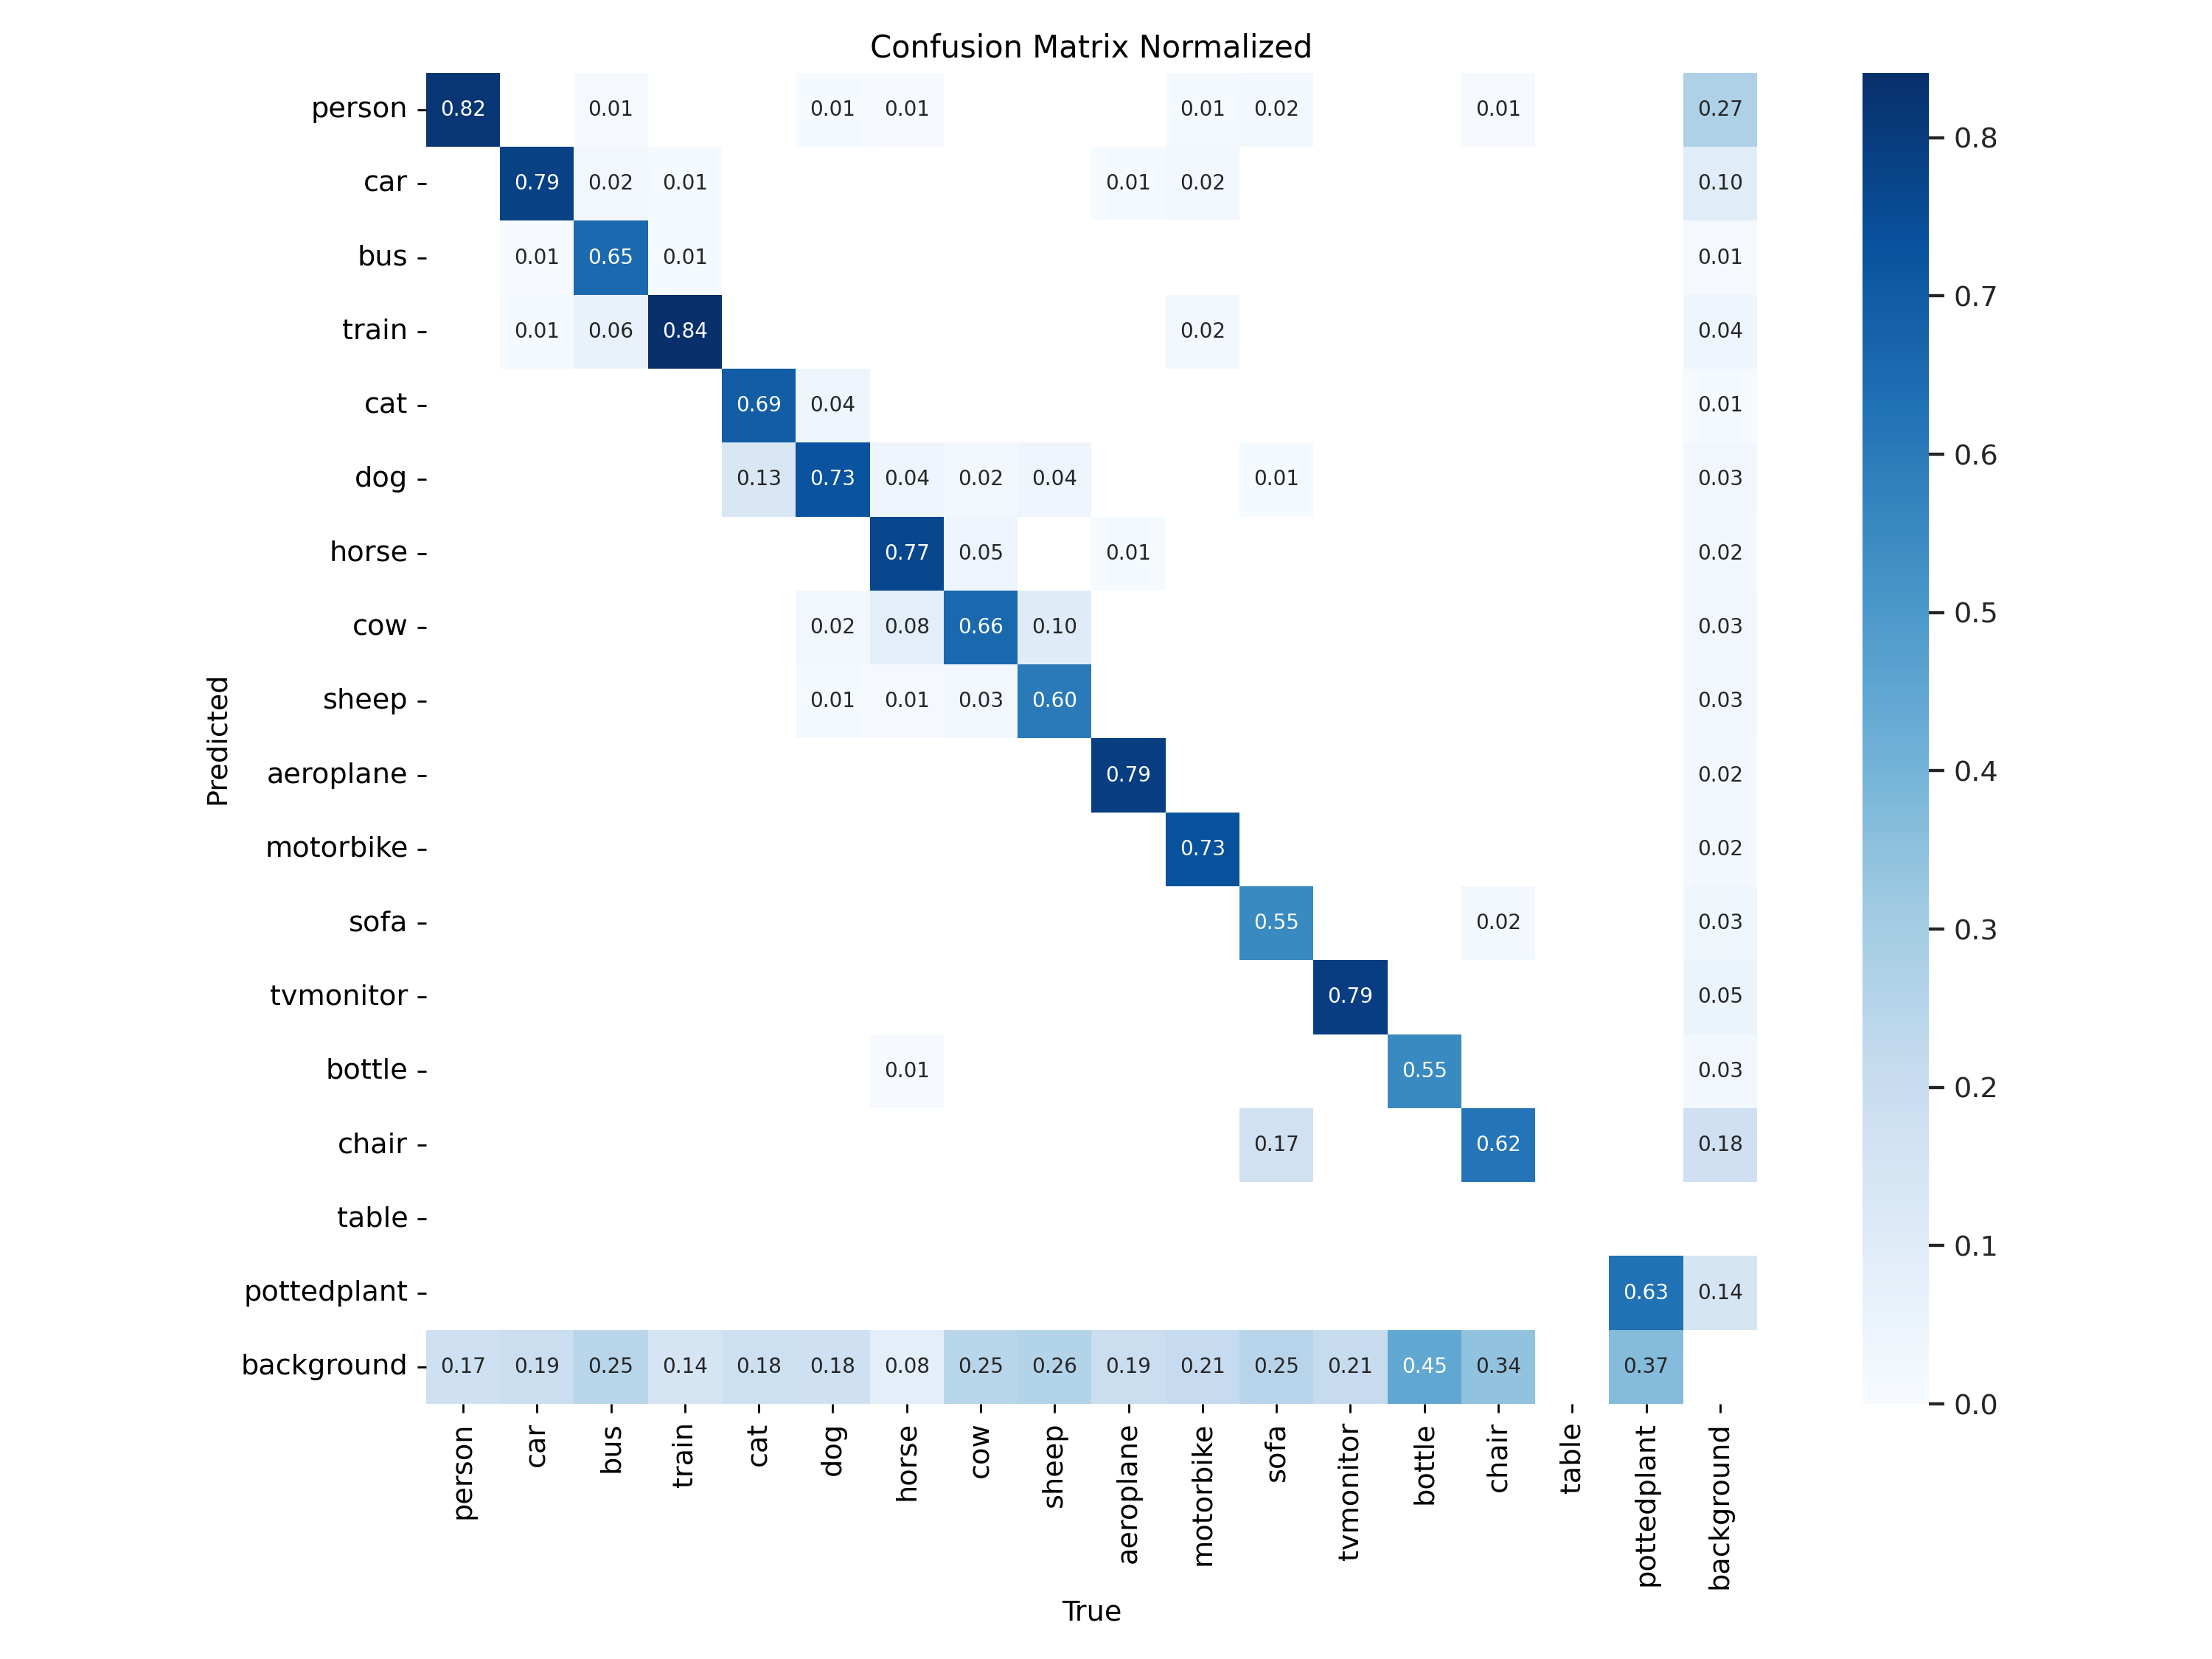

In [17]:
Image.open("/content/runs/detect/train/confusion_matrix_normalized.png")

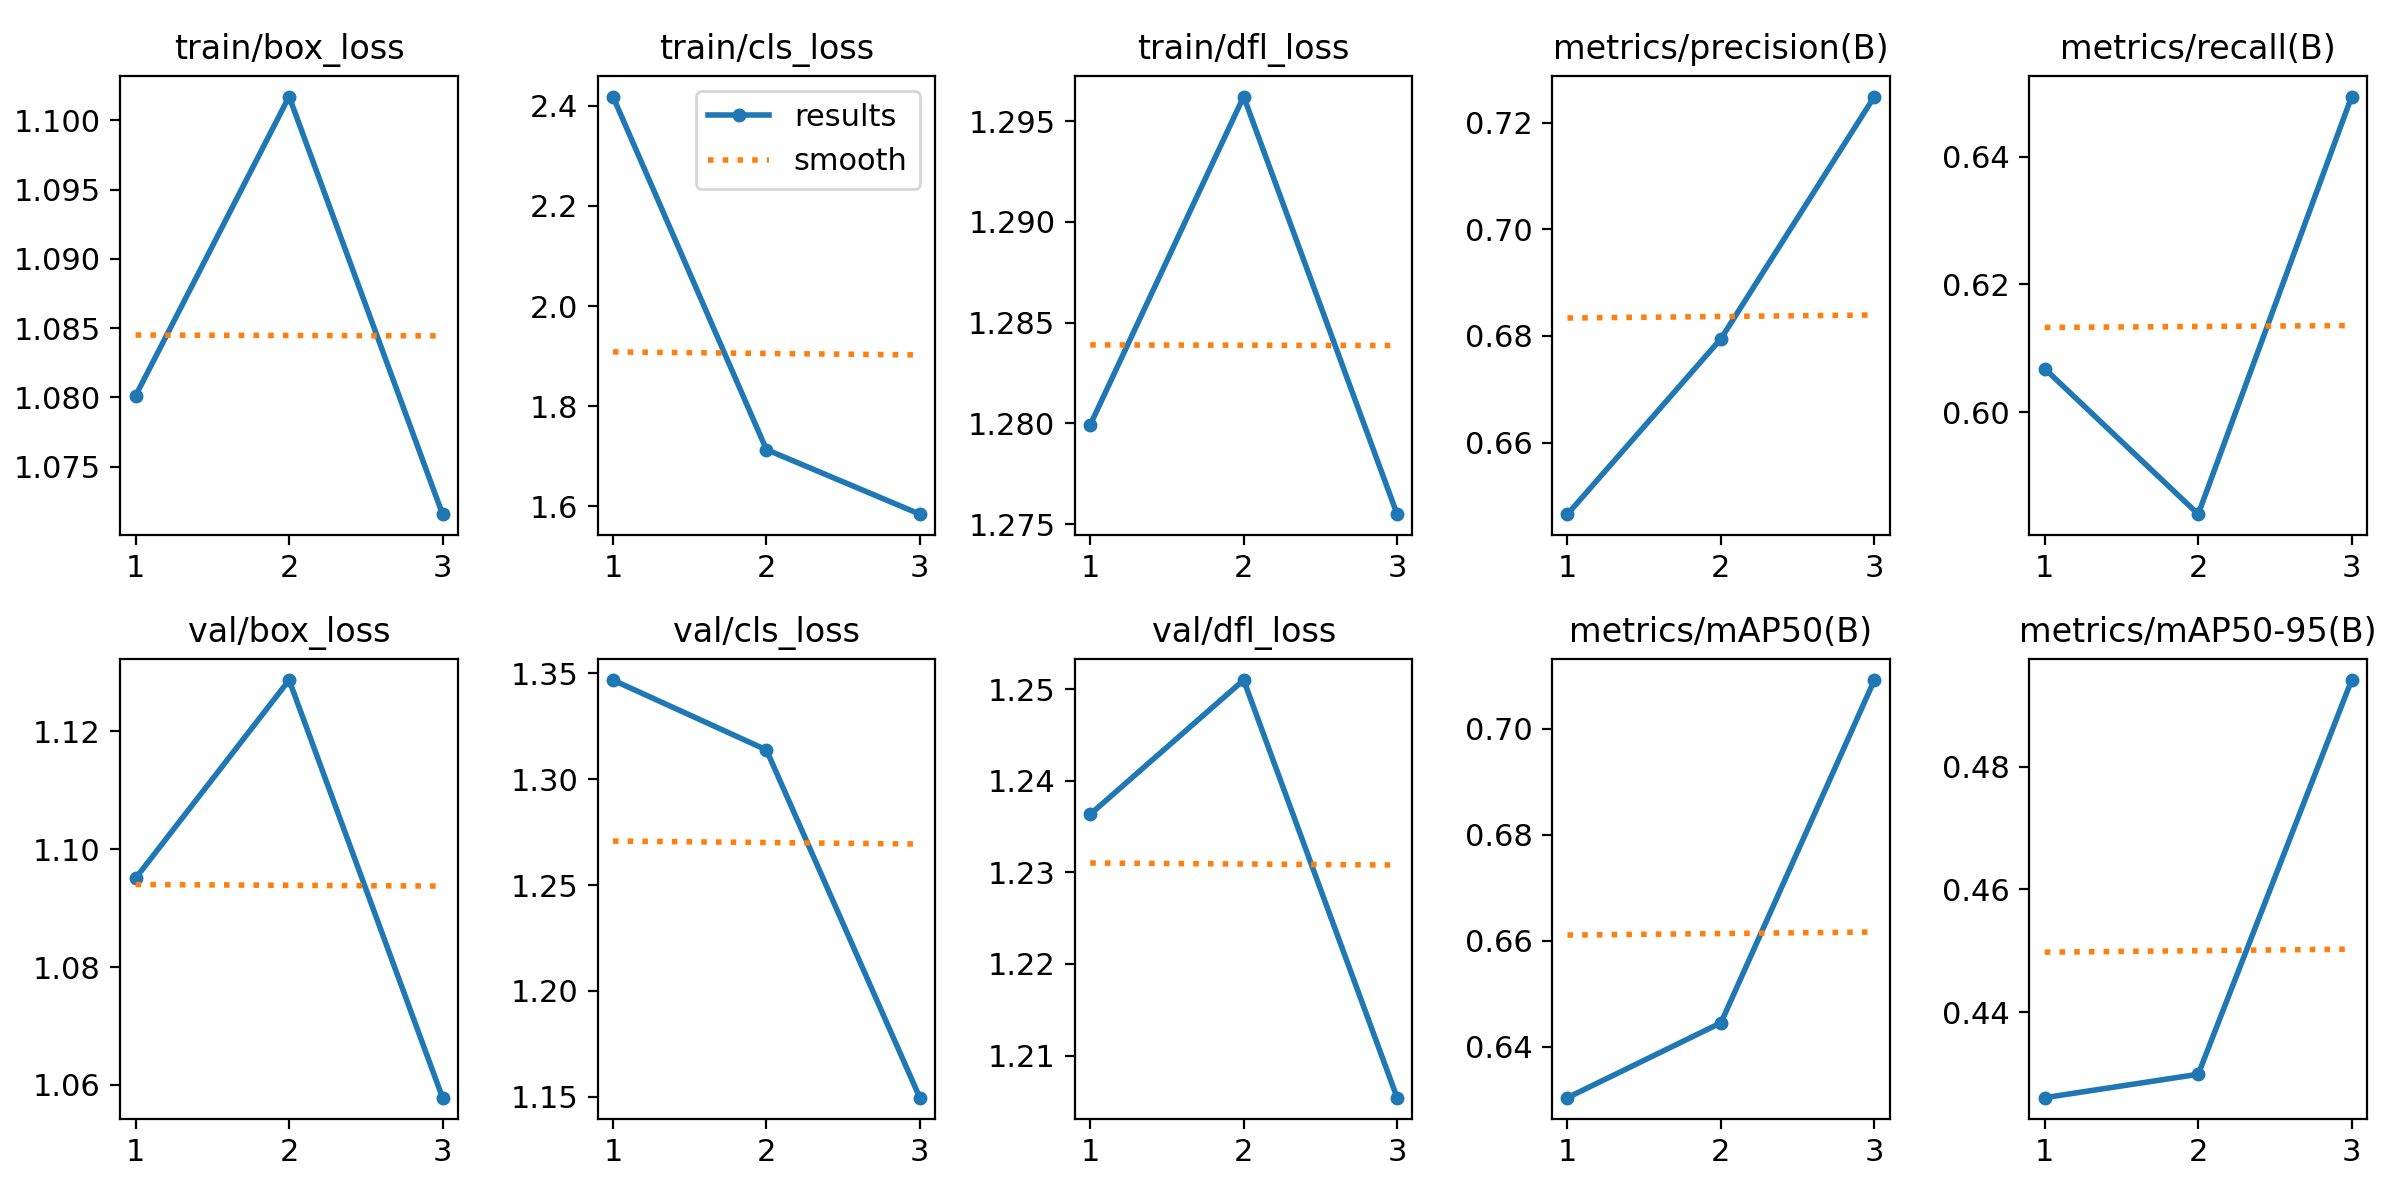

In [18]:
Image.open("/content/runs/detect/train/results.png")

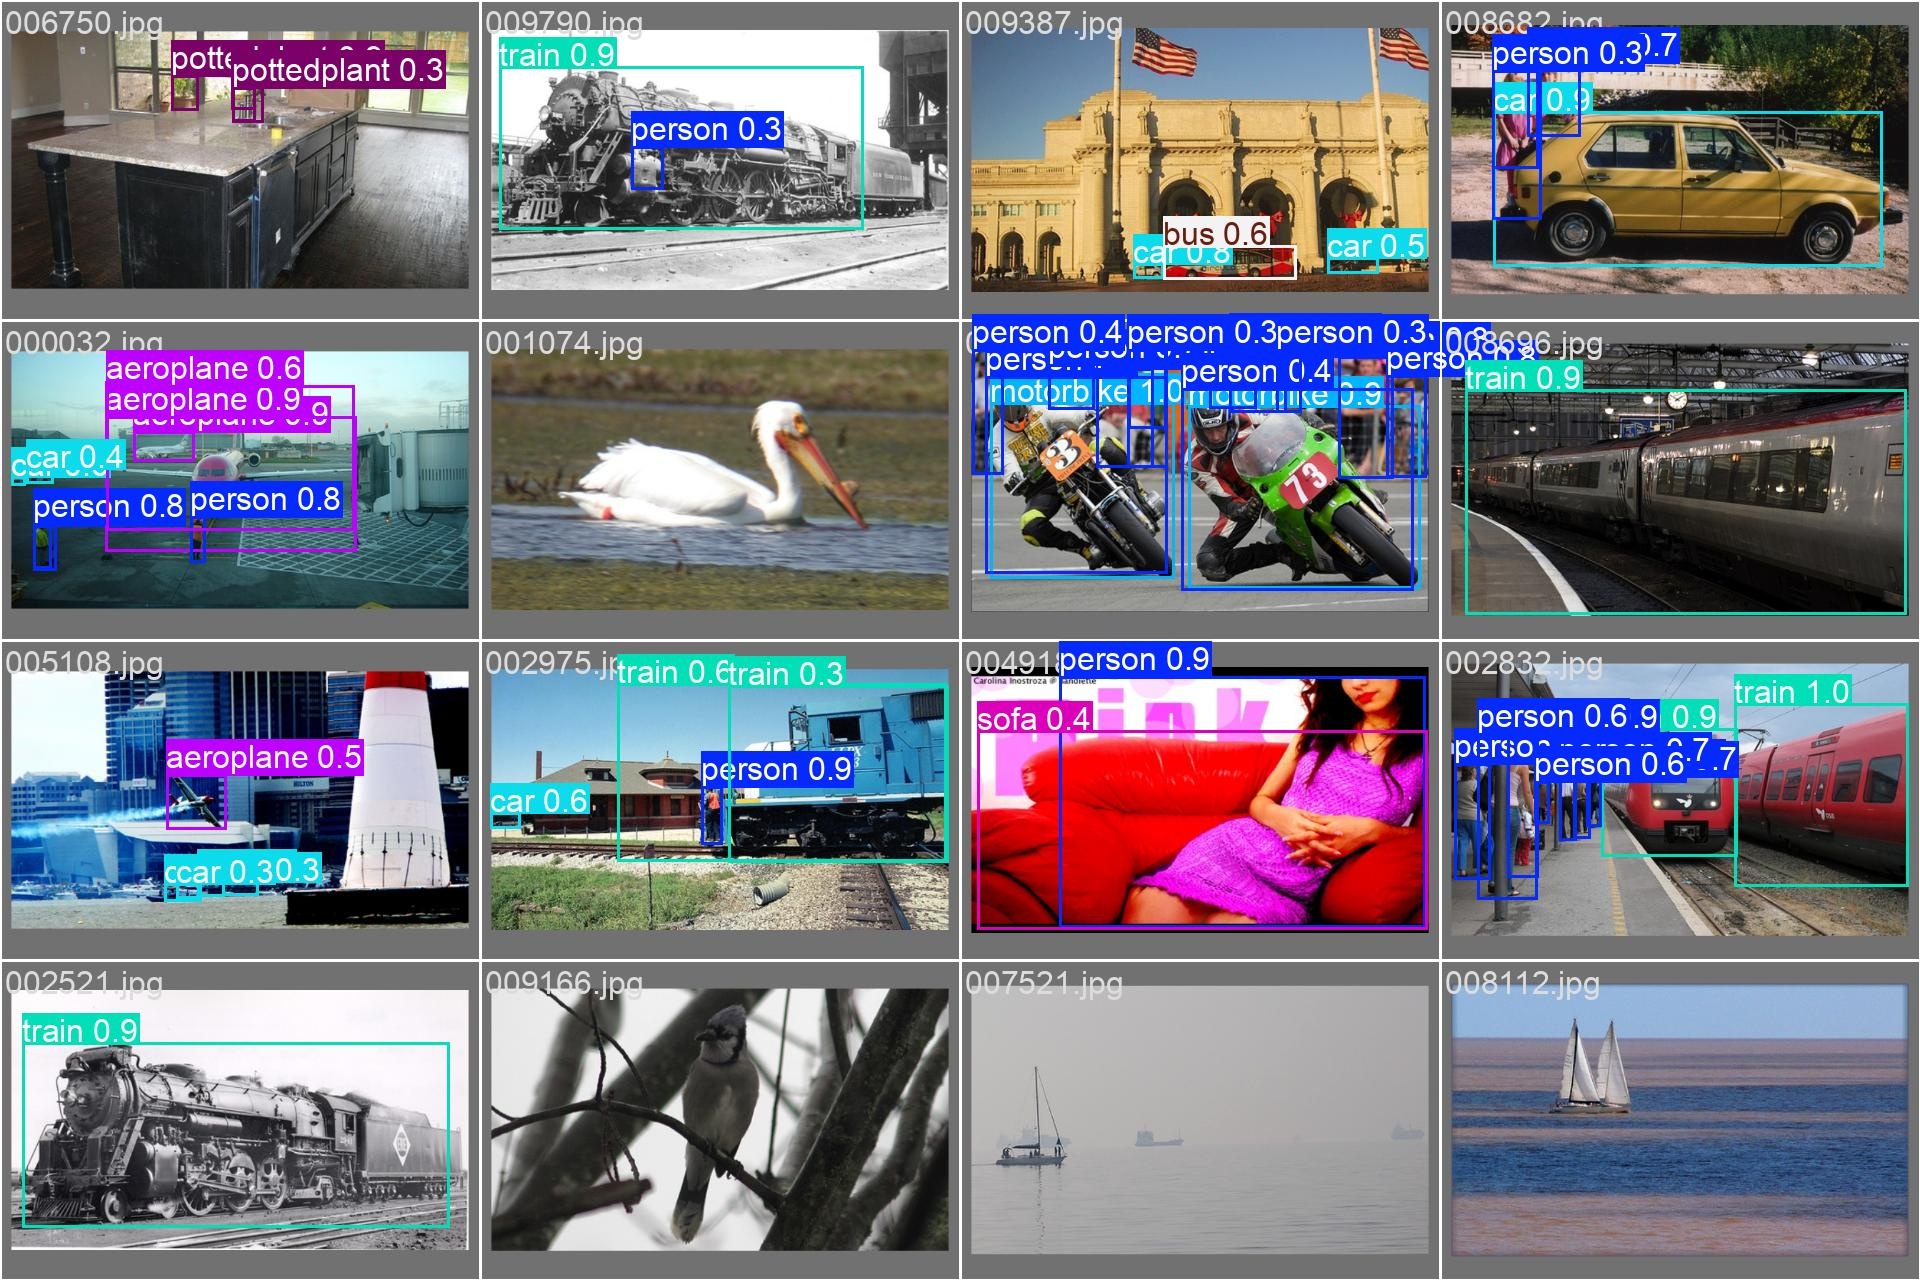

In [19]:
Image.open("/content/runs/detect/train/val_batch1_pred.jpg")